### PoC Proof of Concept - Auslesen Daten Sensoneo Füllstandsensoren
Für PoC wurden die Daten von der Sigfox Plattform in csv-From heruntergeladen. Hier werden die Daten des Füllstandsensors der bei Kompotoi montiert ist ausgelesen 

In [1]:
# import librarys
import pandas as pd
import glob
import os
import numpy as np
import re
import matplotlib.pyplot as plt 
import matplotlib as mpl
import datetime as dt
import scipy.stats
#print(plt.style.available)
# optional: for ggplot-like style
mpl.style.use(['ggplot']) 
# damit plt.show() nicht benötigt wird
%matplotlib inline

#### Alle 'page' files von Sigfox Plattform im Datenorder einlesen

In [2]:
path_data = r'./data/sensoneo/S1'
# advisable to use os.path.join as this makes concatenation OS independent
all_files = glob.glob(os.path.join(path_data + '/*.csv'))
len(all_files), all_files[0]

(3, './data/sensoneo/S1\\export-device-34EF62-messages_p1.csv')

In [3]:
# lese alle files im Ordner (Achtung: csv file Daten von Plattform mit ; getrennt)
df_sensoneo = pd.concat((pd.read_csv(f, sep=';') for f in all_files), ignore_index=True)
df_sensoneo.head(3)

,Country,Data,Device ID,Timestamp
0,NaN,b92a0070010c0c0c0c6e0c3f,0034EF62,2021-05-04 07:05:30
1,NaN,b92a0070010c0c0c0c6e0a3e,0034EF62,2021-05-04 05:05:31
2,NaN,b92a0070010b0b0b0b6e0a3d,0034EF62,2021-05-04 03:05:27


#### DF fast clean up

In [4]:
# set Timestamp as index
df_sensoneo.index = pd.to_datetime(df_sensoneo['Timestamp'])
# drop na columne country
df_sensoneo.drop('Timestamp', axis=1, inplace=True)
df_sensoneo.drop('Country', axis=1, inplace=True)
df_sensoneo.head(2)

,Data,Device ID
Timestamp,,
2021-05-04 07:05:30,b92a0070010c0c0c0c6e0c3f,0034EF62
2021-05-04 05:05:31,b92a0070010c0c0c0c6e0a3e,0034EF62


In [5]:
df_sensoneo.loc['2021']

,Data,Device ID
Timestamp,,
2021-05-04 07:05:30,b92a0070010c0c0c0c6e0c3f,0034EF62
2021-05-04 05:05:31,b92a0070010c0c0c0c6e0a3e,0034EF62
2021-05-04 03:05:27,b92a0070010b0b0b0b6e0a3d,0034EF62
2021-05-04 01:05:25,b92a0070010b0b0b0b6e0c3c,0034EF62
2021-05-03 23:05:24,b92a0070010b0b0b0b6f0e3b,0034EF62
...,...,...
2021-04-13 17:06:56,b92a0070013d3d3d3d6e0b3e,0034EF62
2021-04-13 15:06:55,b92a0070013c3c3c3c6e0c3d,0034EF62
2021-04-13 13:07:15,b92a0070010c0c0c0c6e0c3c,0034EF62


### System Daten Decodieren

In [6]:
test_string = df_sensoneo['Data'][0]
print(test_string)

b92a0070010c0c0c0c6e0c3f


#### Regex Versuche
[link](https://teams.microsoft.com/l/file/4CA28045-DAEC-424F-AEE1-A8C95639BA28?tenantId=9d1a5fc8-321e-4101-ae63-530730711ac2&fileType=pdf&objectUrl=https%3A%2F%2Ffhnw365.sharepoint.com%2Fteams%2FDSP2-FS21_M365-Team-A-Kompotoi%2FFreigegebene%20Dokumente%2FTeam-A-Kompotoi%2F04_Team%2F03_Sensoren%2FSensoneo%20Quatro%20and%20Single%20sensor%203.0_Payload%20description_Sigfox.pdf&baseUrl=https%3A%2F%2Ffhnw365.sharepoint.com%2Fteams%2FDSP2-FS21_M365-Team-A-Kompotoi&serviceName=teams&threadId=19:75ef1c08a4394f1db0837bb23e19fc7f@thread.tacv2&groupId=ed0cd89c-53d5-4735-914a-68d96e24379f)

In [7]:
# Sensor ID festlegen
senId = 'b92a'
#senId = '972a'
# Hex daten aufsplitten
# full_pattern = sendId + r'b92a00700\w\w\w\w\w\w\w\w\w\w\w\w\w\w\w'
pat_distance01 = senId + r'00700\w(\w\w)\w\w\w\w\w\w\w\w\w\w\w\w'
pat_distance02 = senId + r'00700\w\w\w(\w\w)\w\w\w\w\w\w\w\w\w\w'
pat_distance03 = senId + r'00700\w\w\w\w\w(\w\w)\w\w\w\w\w\w\w\w'
pat_distance04 = senId + r'00700\w\w\w\w\w\w\w(\w\w)\w\w\w\w\w\w'
pat_voltage    = senId + r'00700\w\w\w\w\w\w\w\w\w(\w\w)\w\w\w\w'
pat_temperatur = senId + r'00700\w\w\w\w\w\w\w\w\w\w\w(\w\w)\w\w'
pat_event_count = senId + r'00700\w{13}(\w\w)'

# Hex-code
hex_distance01 = str(re.findall(pat_distance01, test_string)[0])
hex_distance02 = str(re.findall(pat_distance02, test_string)[0])
hex_distance03 = str(re.findall(pat_distance03, test_string)[0])
hex_distance04 = str(re.findall(pat_distance04, test_string)[0])
hex_voltage    = str(re.findall(pat_voltage, test_string)[0])
hex_temperatur = str(re.findall(pat_temperatur, test_string)[0])
hex_event_count = str(re.findall(pat_event_count, test_string)[0])

# Umrechnungen
distance_cm_01  = int(hex_distance01, 16)*2
distance_cm_02  = int(hex_distance02, 16)*2
distance_cm_03  = int(hex_distance03, 16)*2
distance_cm_04  = int(hex_distance04, 16)*2
voltage_mV  = (int(hex_voltage, 16)*10) + 2500
temperatur  = int(hex_temperatur, 16)
event_count = int(hex_event_count, 16)

print('Distanz [cm] 01: ', distance_cm_01, '\t','Distanz 01(hex): ', '\t', hex_distance01)
print('Distanz [cm] 02: ', distance_cm_02, '\t','Distanz 02(hex): ', '\t', hex_distance02)
print('Distanz [cm] 03: ', distance_cm_03, '\t','Distanz 03(hex): ', '\t', hex_distance03)
print('Distanz [cm] 04: ', distance_cm_04, '\t','Distanz 04(hex): ', '\t', hex_distance04)
print('Spannung [mV]: ', voltage_mV, '\t','Spannung(hex): ', '\t', hex_voltage)
print('Temperatur: ', temperatur, '\t','Temperatur(hex): ', '\t', hex_temperatur)
print('Event Counter: ', event_count, '\t','Event Counter(hex): ', '\t', hex_event_count)

measurements = {'distance':[distance_cm_01,distance_cm_02,distance_cm_03,distance_cm_04], 
                       'Voltage_mV':voltage_mV, 'Temperatur':temperatur, 'Event Count':event_count}
measurements

Distanz [cm] 01:  24 	 Distanz 01(hex):  	 0c
Distanz [cm] 02:  24 	 Distanz 02(hex):  	 0c
Distanz [cm] 03:  24 	 Distanz 03(hex):  	 0c
Distanz [cm] 04:  24 	 Distanz 04(hex):  	 0c
Spannung [mV]:  3600 	 Spannung(hex):  	 6e
Temperatur:  12 	 Temperatur(hex):  	 0c
Event Counter:  63 	 Event Counter(hex):  	 3f


{'distance': [24, 24, 24, 24],
 'Voltage_mV': 3600,
 'Temperatur': 12,
 'Event Count': 63}

In [8]:
# Als Funktion
def data_decoder(data, print_for_debug = False):
    # Sensor ID festlegen
    senId = 'b92a'
    #senId = '972a'
    # Hex daten aufsplitten
    # full_pattern = sendId + r'b92a00700\w\w\w\w\w\w\w\w\w\w\w\w\w\w\w'
    pat_distance01 = senId + r'00700\w(\w\w)\w\w\w\w\w\w\w\w\w\w\w\w'
    pat_distance02 = senId + r'00700\w\w\w(\w\w)\w\w\w\w\w\w\w\w\w\w'
    pat_distance03 = senId + r'00700\w\w\w\w\w(\w\w)\w\w\w\w\w\w\w\w'
    pat_distance04 = senId + r'00700\w\w\w\w\w\w\w(\w\w)\w\w\w\w\w\w'
    pat_voltage    = senId + r'00700\w\w\w\w\w\w\w\w\w(\w\w)\w\w\w\w'
    pat_temperatur = senId + r'00700\w\w\w\w\w\w\w\w\w\w\w(\w\w)\w\w'
    pat_event_count = senId + r'00700\w{13}(\w\w)'
    
    # Hex-code
    hex_distance01 = str(re.findall(pat_distance01, data)[0])
    hex_distance02 = str(re.findall(pat_distance02, data)[0])
    hex_distance03 = str(re.findall(pat_distance03, data)[0])
    hex_distance04 = str(re.findall(pat_distance04, data)[0])
    hex_voltage    = str(re.findall(pat_voltage, data)[0])
    hex_temperatur = str(re.findall(pat_temperatur, data)[0])
    hex_event_count = str(re.findall(pat_event_count, data)[0])
    
    # Umrechnungen
    distance_cm_01  = int(hex_distance01, 16)*2
    distance_cm_02  = int(hex_distance02, 16)*2
    distance_cm_03  = int(hex_distance03, 16)*2
    distance_cm_04  = int(hex_distance04, 16)*2
    voltage_mV  = (int(hex_voltage, 16)*10) + 2500
    temperatur  = int(hex_temperatur, 16)
    event_count = int(hex_event_count, 16)
    
    if print_for_debug:
        print('Distanz [cm] 01: ', distance_cm_01, '\t','Distanz 01(hex): ', '\t', hex_distance01)
        print('Distanz [cm] 02: ', distance_cm_02, '\t','Distanz 02(hex): ', '\t', hex_distance02)
        print('Distanz [cm] 03: ', distance_cm_03, '\t','Distanz 03(hex): ', '\t', hex_distance03)
        print('Distanz [cm] 04: ', distance_cm_04, '\t','Distanz 04(hex): ', '\t', hex_distance04)
        print('Spannung [mV]: ', voltage_mV, '\t','Spannung(hex): ', '\t', hex_voltage)
        print('Temperatur: ', temperatur, '\t','Temperatur(hex): ', '\t', hex_temperatur)
        print('Event Counter: ', event_count, '\t','Event Counter(hex): ', '\t', hex_event_count)
        
        
    measurements = {'Distance':[distance_cm_01,distance_cm_02,distance_cm_03,distance_cm_04], 
                       'Voltage_mV':voltage_mV, 'Temperatur':temperatur, 'Event_Count':event_count}
    return measurements

In [9]:
sensor_data = data_decoder(test_string, print_for_debug = False)
sensor_data

{'Distance': [24, 24, 24, 24],
 'Voltage_mV': 3600,
 'Temperatur': 12,
 'Event_Count': 63}

### Anwendung Decodieren

In [10]:
# Neue (Mess-)Spalten hinzufügen
df_sensoneo['Distance']    = 0
df_sensoneo['Temperatur']  = 0
df_sensoneo['Voltage_mV'] = 0
df_sensoneo['Event_Count'] = 0
df_sensoneo.head(2)

,Data,Device ID,Distance,Temperatur,Voltage_mV,Event_Count
Timestamp,,,,,,
2021-05-04 07:05:30,b92a0070010c0c0c0c6e0c3f,0034EF62,0,0,0,0
2021-05-04 05:05:31,b92a0070010c0c0c0c6e0a3e,0034EF62,0,0,0,0


In [11]:
#df_sensoneo.columns
#index = df_sensoneo.index(0)
#df_sensoneo.columns.get_loc('Voltage_mV')

In [12]:
# for i, row in enumerate(df_sensoneo['Data']):
#     index = df_sensoneo.index(i)
#     df_sensoneo.iloc[index, 2] = data_decoder(row)['Distance'][0]
#     df_sensoneo.iloc[index, 3]  = data_decoder(row)['Temperatur']
#     df_sensoneo.iloc[index, 4] = data_decoder(row)['Voltage_mV']
#     df_sensoneo.iloc[index, 5] = data_decoder(row)['Event_Count']

In [13]:
for index, row in enumerate(df_sensoneo['Data']):
    df_sensoneo.iloc[index, df_sensoneo.columns.get_loc('Distance')] = data_decoder(row)['Distance'][0]
    df_sensoneo.iloc[index, df_sensoneo.columns.get_loc('Temperatur')]  = data_decoder(row)['Temperatur']
    df_sensoneo.iloc[index, df_sensoneo.columns.get_loc('Voltage_mV')] = data_decoder(row)['Voltage_mV']
    df_sensoneo.iloc[index, df_sensoneo.columns.get_loc('Event_Count')] = data_decoder(row)['Event_Count']

In [14]:
df_sensoneo.head(100)
df_sensoneo.loc['2021-04-23']

,Data,Device ID,Distance,Temperatur,Voltage_mV,Event_Count
Timestamp,,,,,,
2021-04-23 23:06:25,b92a0070010a0a0a0a6f0ebd,0034EF62,20,14,3610,189
2021-04-23 21:06:23,b92a007001090909097010bc,0034EF62,18,16,3620,188
2021-04-23 19:06:21,b92a007001080808087012bb,0034EF62,16,18,3620,187
2021-04-23 17:06:20,b92a007001090909097015ba,0034EF62,18,21,3620,186
2021-04-23 15:06:19,b92a0070013b3b3b3b7015b9,0034EF62,118,21,3620,185
2021-04-23 13:06:18,b92a0070013a3a3a3a7015b8,0034EF62,116,21,3620,184
2021-04-23 11:06:16,b92a0070010d0d0d0d6f10b7,0034EF62,26,16,3610,183
2021-04-23 09:06:14,b92a0070010d0d0d0d6e0bb6,0034EF62,26,11,3600,182
2021-04-23 07:06:13,b92a0070010c0c0c0c6e0bb5,0034EF62,24,11,3600,181


------------------------------------------------------------
### Grafische Auswertungen

#### Test Auswertungen mit Temperaturen und Event Counter zum prüfen ob decodierte Daten Sinn machen

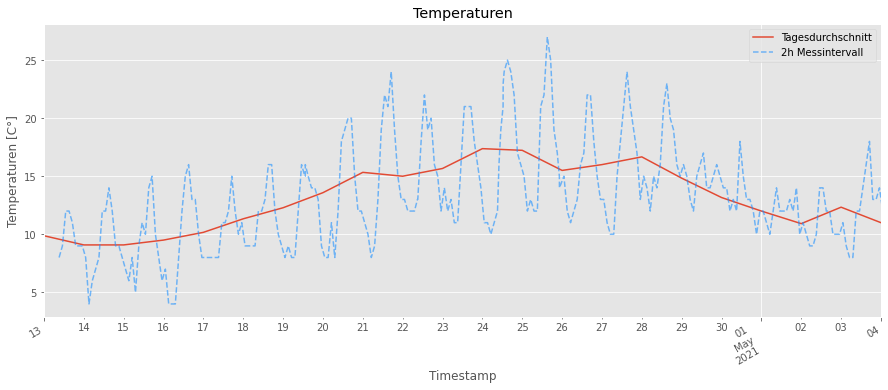

In [15]:
# Temperaturen
df_sensoneo['Temperatur'].resample('D').mean().plot(figsize=(15,6), label='Tagesdurchschnitt')
df_sensoneo['Temperatur'].plot(figsize=(15,6), color='dodgerblue', alpha=0.6, linestyle='--', label='2h Messintervall')
plt.title('Temperaturen')
plt.ylabel('Temperaturen [C°]')
plt.legend()
plt.savefig('./Jupyter Notebook Grafiken/Füllstandsensor1_Temperatur.png')
plt.show()

Nach prüfen Wetterdaten für den Raum Zürich besteht ein Offset der Temperatur, der Verlauf stimmt aber überrein (max zwischen 24.04 und 28.04) [link](https://www.accuweather.com/de/ch/zurich/316622/april-weather/316622)

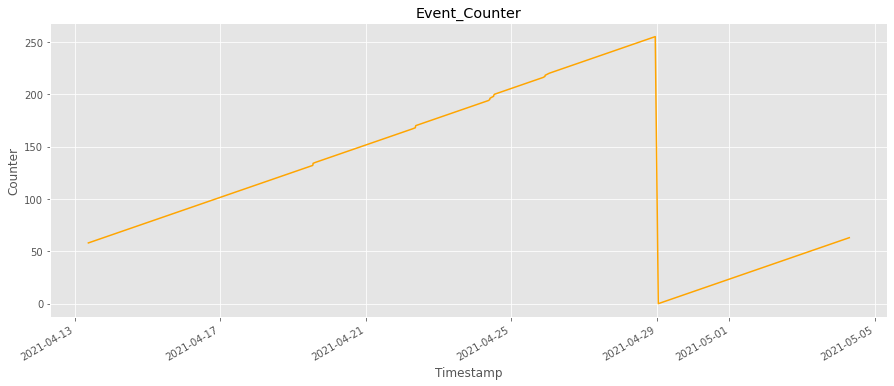

In [16]:
# Event Counter
df_sensoneo['Event_Count'].plot(color='orange', figsize=(15,6))
plt.title('Event_Counter')
plt.ylabel('Counter')
plt.savefig('./Jupyter Notebook Grafiken/Füllstandsensor1_Event Counter.png')
plt.show()

Event Counter von 255 zurück auf 0 -> Falls Messwerte vermisst werden auf diff() prüfen.

In [17]:
# pandas slicing mit sollte direkt möglich sein ..?
#df_sensoneo.loc['2021-04-18','2021-04-26']
df_sensoneo.loc['2021-4-25']

,Data,Device ID,Distance,Temperatur,Voltage_mV,Event_Count
Timestamp,,,,,,
2021-04-25 22:24:17,b92a007001171717176d0eda,0034EF62,46,14,3590,218
2021-04-25 22:21:05,b92a0070043c3c3c3c6f0fd9,0034EF62,120,15,3610,217
2021-04-25 21:06:15,b92a0070013c3c3c3c7011d8,0034EF62,120,17,3620,216
2021-04-25 19:06:13,b92a007001171717177013d7,0034EF62,46,19,3620,215
2021-04-25 17:06:12,b92a007001050505057119d6,0034EF62,10,25,3630,214
2021-04-25 15:06:11,b92a00700119191919701bd5,0034EF62,50,27,3620,213
2021-04-25 13:06:09,b92a0070011e1e1e1e7016d4,0034EF62,60,22,3620,212
2021-04-25 11:06:08,b92a0070011d1d1d1d7015d3,0034EF62,58,21,3620,211
2021-04-25 09:06:07,b92a0070013c3c3c3c6e0cd2,0034EF62,120,12,3600,210


#### Interpretationen
Die Distanz von 120cm wird gemessen wenn der WC Deckel offen bleibt (für jeweils Türe offen/geschlossen). Die min. Distanz bei leerem Behälter war vor Ort ~41cm. Sensor Installation am 26. März, Messdaten aber erst seit Callbacks auf Sigfox Plattform vorhanden !?  
Messwerte grösse 100cm können entfernt werden. -> WC Deckel nicht zu  
Messwerte kleiner 5 können entfernt werden. -> Personen sitzt auf dem WC

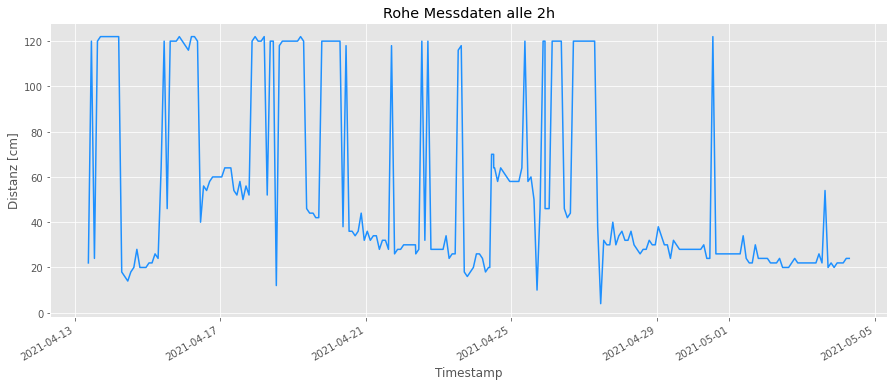

In [18]:
df_sensoneo['Distance'].plot(color='dodgerblue', figsize=(15,6))
plt.title('Rohe Messdaten alle 2h')
plt.ylabel('Distanz [cm]')
plt.savefig('./Jupyter Notebook Grafiken/Füllstandsensor1_Rohdaten.png')
plt.show()

In [19]:
# Daten filtern und entfernen
#df_sensoneo = df_sensoneo[df_sensoneo['Distance'] < 100]
#df_sensoneo = df_sensoneo[df_sensoneo['Distance'] > 5]

#### Daten filter und ersetzen

In [20]:
# Daten filtern und NA's schreiben
df_sensoneof1 = df_sensoneo
df_sensoneof1['Distance'] = df_sensoneof1['Distance'].astype('float')
df_sensoneof1['Distance'] = np.where(df_sensoneof1['Distance'] <= 100, df_sensoneof1['Distance'], pd.NA)  #np.nan
df_sensoneof1['Distance'] = np.where(df_sensoneof1['Distance'] >= 5, df_sensoneof1['Distance'], pd.NA)
df_sensoneof1

,Data,Device ID,Distance,Temperatur,Voltage_mV,Event_Count
Timestamp,,,,,,
2021-05-04 07:05:30,b92a0070010c0c0c0c6e0c3f,0034EF62,24,12,3600,63
2021-05-04 05:05:31,b92a0070010c0c0c0c6e0a3e,0034EF62,24,10,3600,62
2021-05-04 03:05:27,b92a0070010b0b0b0b6e0a3d,0034EF62,22,10,3600,61
2021-05-04 01:05:25,b92a0070010b0b0b0b6e0c3c,0034EF62,22,12,3600,60
2021-05-03 23:05:24,b92a0070010b0b0b0b6f0e3b,0034EF62,22,14,3610,59
...,...,...,...,...,...,...
2021-04-13 17:06:56,b92a0070013d3d3d3d6e0b3e,0034EF62,<NA>,11,3600,62
2021-04-13 15:06:55,b92a0070013c3c3c3c6e0c3d,0034EF62,<NA>,12,3600,61
2021-04-13 13:07:15,b92a0070010c0c0c0c6e0c3c,0034EF62,24,12,3600,60


In [21]:
# Daten filtern und NA's mit ffill füllen
df_sensoneof1['Distance'].fillna(method='ffill', inplace = True)
df_sensoneof1

,Data,Device ID,Distance,Temperatur,Voltage_mV,Event_Count
Timestamp,,,,,,
2021-05-04 07:05:30,b92a0070010c0c0c0c6e0c3f,0034EF62,24.0,12,3600,63
2021-05-04 05:05:31,b92a0070010c0c0c0c6e0a3e,0034EF62,24.0,10,3600,62
2021-05-04 03:05:27,b92a0070010b0b0b0b6e0a3d,0034EF62,22.0,10,3600,61
2021-05-04 01:05:25,b92a0070010b0b0b0b6e0c3c,0034EF62,22.0,12,3600,60
2021-05-03 23:05:24,b92a0070010b0b0b0b6f0e3b,0034EF62,22.0,14,3610,59
...,...,...,...,...,...,...
2021-04-13 17:06:56,b92a0070013d3d3d3d6e0b3e,0034EF62,18.0,11,3600,62
2021-04-13 15:06:55,b92a0070013c3c3c3c6e0c3d,0034EF62,18.0,12,3600,61
2021-04-13 13:07:15,b92a0070010c0c0c0c6e0c3c,0034EF62,24.0,12,3600,60


#### Distanzen "drehen" , Sensor misst Distanz zum Behälterboden. Distanz nimmt mit zunehmender Füllmenge ab. Drehen damit man die Zunahme des Werts sieht -> Intuitiver

In [22]:
# Distance daten drehen
max_Füllmenge = 75
for i, row in enumerate(df_sensoneof1['Distance']):
    df_sensoneof1.iloc[i, df_sensoneof1.columns.get_loc('Distance')] = max_Füllmenge - df_sensoneof1.iloc[i, df_sensoneof1.columns.get_loc('Distance')]
df_sensoneof1

,Data,Device ID,Distance,Temperatur,Voltage_mV,Event_Count
Timestamp,,,,,,
2021-05-04 07:05:30,b92a0070010c0c0c0c6e0c3f,0034EF62,51.0,12,3600,63
2021-05-04 05:05:31,b92a0070010c0c0c0c6e0a3e,0034EF62,51.0,10,3600,62
2021-05-04 03:05:27,b92a0070010b0b0b0b6e0a3d,0034EF62,53.0,10,3600,61
2021-05-04 01:05:25,b92a0070010b0b0b0b6e0c3c,0034EF62,53.0,12,3600,60
2021-05-03 23:05:24,b92a0070010b0b0b0b6f0e3b,0034EF62,53.0,14,3610,59
...,...,...,...,...,...,...
2021-04-13 17:06:56,b92a0070013d3d3d3d6e0b3e,0034EF62,57.0,11,3600,62
2021-04-13 15:06:55,b92a0070013c3c3c3c6e0c3d,0034EF62,57.0,12,3600,61
2021-04-13 13:07:15,b92a0070010c0c0c0c6e0c3c,0034EF62,51.0,12,3600,60


#### Distanz Messdaten prüfen

In [23]:
#df_sensoneo.index.hour

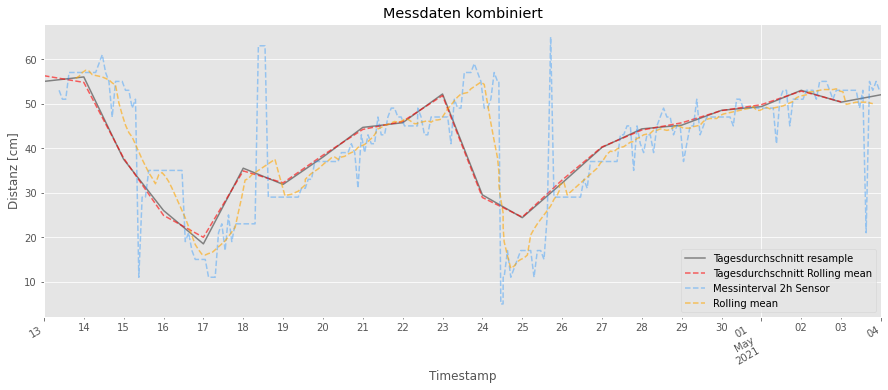

In [24]:
dates = df_sensoneof1.index.date
#dates = dates + pd.DataOffset(1)

#df_sensoneo['Distance'].groupby(dates).mean().plot(color='red', label='Tagesdurchschnitt groupby')
df_sensoneof1['Distance'].resample('D').mean().shift(0).plot(color='gray', label='Tagesdurchschnitt resample')
df_sensoneof1['Distance'].rolling(12,center=True).mean().resample('D').mean().plot(color='red', linestyle='--', 
                                                                     alpha=0.6, label='Tagesdurchschnitt Rolling mean')

df_sensoneof1['Distance'].plot(color='dodgerblue', linestyle='--', alpha=0.4, figsize=(15,6), label='Messinterval 2h Sensor')
df_sensoneof1['Distance'].rolling(12, center=True).mean().plot(color='orange', linestyle='--', alpha=0.6, 
                                                             label='Rolling mean')
plt.title('Messdaten kombiniert')
plt.ylabel('Distanz [cm]')
plt.legend()
plt.savefig('./Jupyter Notebook Grafiken/Füllstandsensor1_Messdaten Tagesdurchschnitt_f1.png')
plt.show()

In [25]:
#df_sensoneo['Distance'].rolling(12, center=True).mean().plot(color='orange', linestyle='--', alpha=0.6)

### Extended data cleaning
Aussreisser besser eingrenzen. Wenn Distanz bei leerem Behälter (max) 41cm ist, dann alle Messwerte grösser ~45cm entfernen. -> WC Deckel offen und Pissoir besetzt = Messung 70cm. Annahme das WC nicht voll wird, min = 12
Unklarheiten: Zeitraum 15.04 - 18.04 warum Wert grösser als 45cm 

In [26]:
# Daten filtern und NA's schreiben
df_sensoneof2 = df_sensoneo
df_sensoneof2['Distance'] = df_sensoneof2['Distance'].astype('float')
df_sensoneof2['Distance'] = np.where(df_sensoneof2['Distance'] <= 50, df_sensoneof2['Distance'], np.nan)
df_sensoneof2['Distance'] = np.where(df_sensoneof2['Distance'] >= 5, df_sensoneof2['Distance'], np.nan)
# Daten filtern und NA's mit ffill füllen
df_sensoneof2['Distance'].fillna(method='ffill', inplace = True)
df_sensoneof2

,Data,Device ID,Distance,Temperatur,Voltage_mV,Event_Count
Timestamp,,,,,,
2021-05-04 07:05:30,b92a0070010c0c0c0c6e0c3f,0034EF62,NaN,12,3600,63
2021-05-04 05:05:31,b92a0070010c0c0c0c6e0a3e,0034EF62,NaN,10,3600,62
2021-05-04 03:05:27,b92a0070010b0b0b0b6e0a3d,0034EF62,NaN,10,3600,61
2021-05-04 01:05:25,b92a0070010b0b0b0b6e0c3c,0034EF62,NaN,12,3600,60
2021-05-03 23:05:24,b92a0070010b0b0b0b6f0e3b,0034EF62,NaN,14,3610,59
...,...,...,...,...,...,...
2021-04-13 17:06:56,b92a0070013d3d3d3d6e0b3e,0034EF62,47.0,11,3600,62
2021-04-13 15:06:55,b92a0070013c3c3c3c6e0c3d,0034EF62,47.0,12,3600,61
2021-04-13 13:07:15,b92a0070010c0c0c0c6e0c3c,0034EF62,47.0,12,3600,60


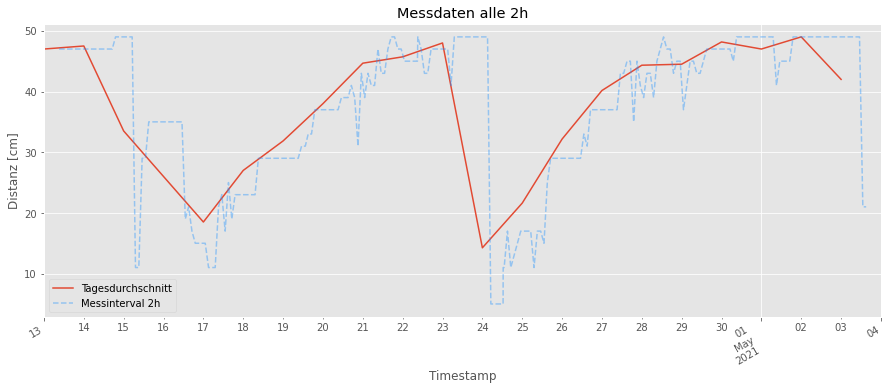

In [27]:
# Alle Wochentage
df_sensoneof2['Distance'].resample('D').mean().plot(label='Tagesdurchschnitt')
df_sensoneof2['Distance'].plot(color='dodgerblue', linestyle='--', alpha=0.4, figsize=(15,6), label='Messinterval 2h')
plt.title('Messdaten alle 2h')
plt.ylabel('Distanz [cm]')
plt.legend()
plt.savefig('./Jupyter Notebook Grafiken/Füllstandsensor1_Messdaten Tagesdurchschnitt_f2.png')
plt.show()

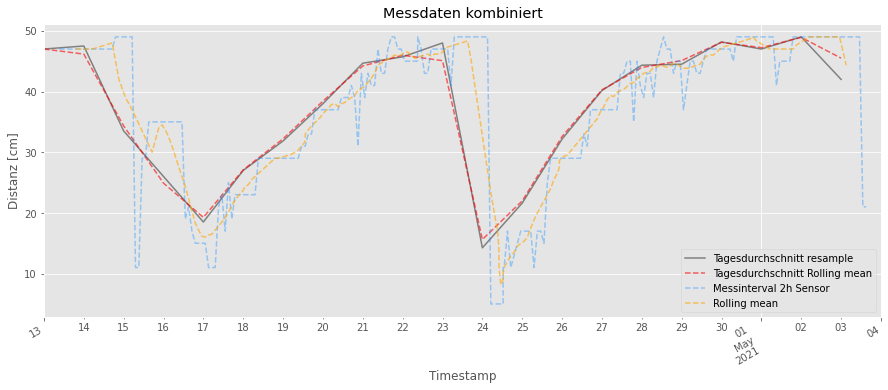

In [28]:
df_sensoneof2['Distance'].resample('D').mean().shift(0).plot(color='gray', label='Tagesdurchschnitt resample')
df_sensoneof2['Distance'].rolling(12,center=True).mean().resample('D').mean().plot(color='red', linestyle='--', 
                                                                     alpha=0.6, label='Tagesdurchschnitt Rolling mean')

df_sensoneof2['Distance'].plot(color='dodgerblue', linestyle='--', alpha=0.4, figsize=(15,6), label='Messinterval 2h Sensor')
df_sensoneof2['Distance'].rolling(12, center=True).mean().plot(color='orange', linestyle='--', alpha=0.6, 
                                                             label='Rolling mean')
plt.title('Messdaten kombiniert')
plt.ylabel('Distanz [cm]')
plt.legend()
plt.savefig('./Jupyter Notebook Grafiken/Füllstandsensor1_Messdaten kombi Tagesdurchschnitt_f2.png')
plt.show()

In [29]:
# Arbeitstage (ohne Wochenende)
# df_sensoneo['Distance'].resample('B').mean().plot(label='Tagesdurchschnitt')
# df_sensoneo['Distance'].plot(color='dodgerblue', linestyle='--', alpha=0.4, figsize=(15,6), label='Messinterval 2h')
# plt.title('Messdaten alle 2h')
# plt.ylabel('Distanz [cm]')
# plt.legend()
# plt.show()
# # Leerungen können auch am Wochenende stattfinden daher nicht geeignet, zeigt aber Wochenende an.

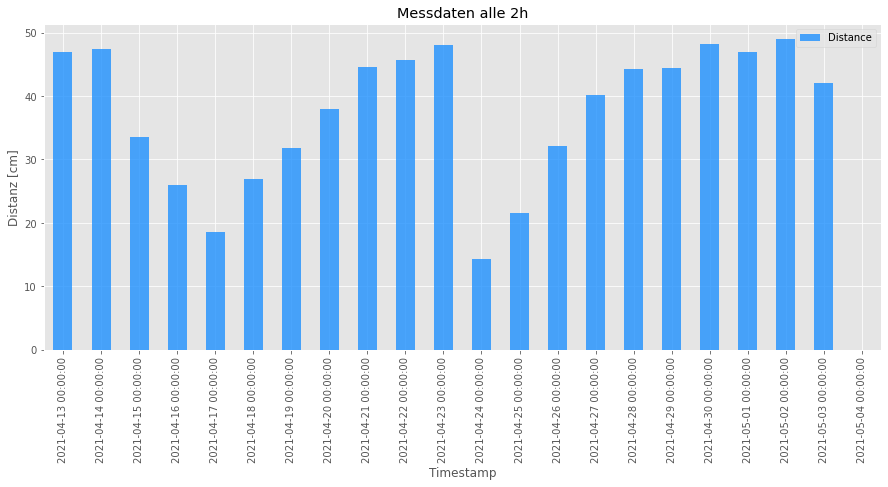

In [30]:
df_sensoneof2['Distance'].resample('D').mean().plot(kind='bar', color='dodgerblue', figsize=(15,6), alpha=0.8)
#df_sensoneo['Distance'].plot(kindcolor='dodgerblue', linestyle='--', alpha=0.4, figsize=(15,6), label='Messinterval 2h')
plt.title('Messdaten alle 2h')
plt.ylabel('Distanz [cm]')
plt.legend()
plt.savefig('./Jupyter Notebook Grafiken/Füllstandsensor1_Messdaten Tagesdurchschnitt_bar.png')
plt.show()

### Fazit
Einzelne Messungen sind schwer zu interpretieren da der WC-Deckel beweglich ist und in allen möglichen Kombinationen messen kann. Nach dem Filtern der Daten zeigt die durchschnittliche Tages Messung wohl die besten Trends. (Vorsichtige) Schätzung würden auf eine Leerung am 18.04 und 25.04 hindeuten 

Messmöglichkeiten (nicht komplett):
1. Deckel ist geschlossen und misst Behälter Füllstand (ideal)
2. Deckel wurde nicht geschlossen und keine Person ist anwesende (Türe offen zu isst egal) misst ~120cm (filterbar)
3. Deckel wurde nicht geschlossen und misst eine Person am Urinal (problematisch)
4. Deckel ist nicht geschlossen da eine Person auf der Toilette sitzt, Distanz sehr klein (filterbar)

#### Weitere Möglichkeiten
Alarmierung bei unterschreiten einer Distanz

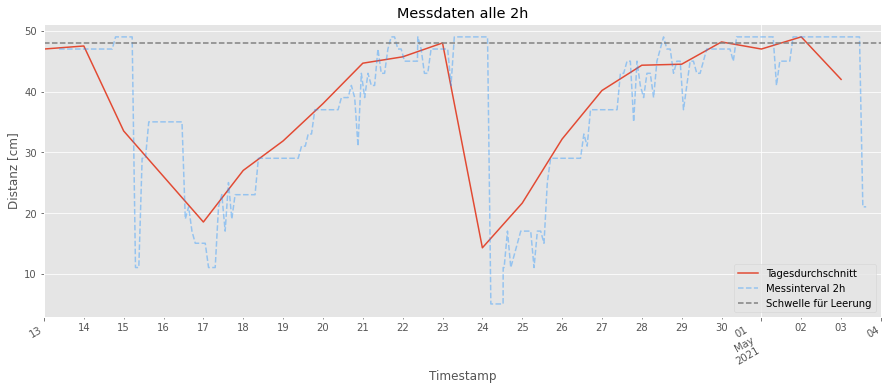

In [31]:
df_sensoneof2['Distance'].resample('D').mean().plot(label='Tagesdurchschnitt')
df_sensoneof2['Distance'].plot(color='dodgerblue', linestyle='--', alpha=0.4, figsize=(15,6), label='Messinterval 2h')
plt.axhline(48, color='gray',linestyle='--', label='Schwelle für Leerung')
plt.title('Messdaten alle 2h')
plt.ylabel('Distanz [cm]')
plt.legend()
plt.savefig('./Jupyter Notebook Grafiken/Füllstandsensor1_Messdaten Tagesdurchschnitt_treshhold.png')
plt.show()

-------------------------------------------------------------
## Vergleich mit den anderen Sensoren

In [32]:
path_data_poc = r'./data/message_data_combined.csv'
df_poc = pd.read_csv(path_data_poc, parse_dates=['created'], index_col='created', low_memory=False)
print(df_poc['deviceId'].value_counts())
df_poc.sort_index(ascending=True, inplace=True)
df_poc

2203AAB    27409
1F25047     2764
2203ACB      752
2203AFA      626
1F2504E      595
2203AF9      201
Name: deviceId, dtype: int64


,Unnamed: 0,_id,timestamp,type,seqNumber,deviceId,__v,action,battery,dl_with_timestamp,...,y_fin,y_max,y_min,z_fin,z_max,z_min,isAlarm,isDismissed,counter,resetDetail
created,,,,,,,,,,,,,,,,,,,,,
2021-03-11 19:41:18.369000+00:00,200,604a725e362d421c28ff3e6f,1615491677,data_bidir,20.0,2203ACB,0,double_press,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.0,NaN
2021-03-11 19:44:08.382000+00:00,199,604a73085486724650bc3a20,1615491846,data_bidir,24.0,2203ACB,0,short_press,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.0,NaN
2021-03-11 19:44:16.283000+00:00,198,604a73105486724650bc3a2b,1615491855,data_bidir,25.0,2203ACB,0,long_press,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.0,NaN
2021-03-11 19:45:37.900000+00:00,196,604a73615486724650bc3b75,1615491936,data_bidir,27.0,2203ACB,0,extra_long_press,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.0,NaN
2021-03-11 19:46:08.718000+00:00,197,604a73805486724650bc3c23,1615491936,service_ack,NaN,2203ACB,0,device_setting_confirmed,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30 23:06:55.354000+00:00,0,608c8d8f1542567911038e7b,1619824014,data_bidir,985.0,2203AAB,0,heartbeat_2,2.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
2021-04-30 23:16:12.445000+00:00,1,608c8fbcc38a49214a7cf304,1619824571,data_bidir,658.0,2203AFA,0,reed_counter,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,281.0,NaN
2021-04-30 23:21:41.977000+00:00,0,608c9105c38a49214a7d0abb,1619824901,data_bidir,659.0,2203AFA,0,reed_counter,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,282.0,NaN


In [33]:
# Zeitraum zwischen Leerung festlegen
df_poc = df_poc[df_poc.index >= '2021-04-17']
df_poc = df_poc[df_poc.index <= '2021-04-25']
df_poc

,Unnamed: 0,_id,timestamp,type,seqNumber,deviceId,__v,action,battery,dl_with_timestamp,...,y_fin,y_max,y_min,z_fin,z_max,z_min,isAlarm,isDismissed,counter,resetDetail
created,,,,,,,,,,,,,,,,,,,,,
2021-04-17 00:54:34.668000+00:00,6623,607a31ca1ef743213da56815,1618620873,data_bidir,796.0,2203AAB,0,heartbeat_2,2.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2021-04-17 02:32:56.664000+00:00,404,607a48d8d131ef466447e562,1618626775,data_bidir,238.0,1F2504E,0,heartbeat_2,2.9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2021-04-17 03:41:09.490000+00:00,1082,607a58d51ef743213da714e6,1618630868,data_bidir,1884.0,1F25047,0,heartbeat_1,2.9,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2021-04-17 03:46:22.619000+00:00,76,607a5a0ed131ef4664489f25,1618631181,data_bidir,147.0,2203AF9,0,heartbeat_1,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2021-04-17 05:55:20.421000+00:00,304,607a7848d131ef46644a0b89,1618638919,data_bidir,517.0,2203ACB,0,heartbeat_1,2.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-24 22:20:08.558000+00:00,188,60849998ab2eff3e2c626938,1619302806,data_bidir,454.0,1F2504E,0,first_move,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2021-04-24 22:21:16.491000+00:00,187,608499dc600a891442b015f1,1619302875,data_bidir,455.0,1F2504E,0,orientation_changed,0.0,0,...,1008.0,1008.0,992.0,-16.0,0.0,-48.0,NaN,NaN,NaN,NaN
2021-04-24 22:21:56.509000+00:00,542,60849a04ab2eff3e2c626d87,1619302915,data_bidir,2446.0,1F25047,0,orientation_changed,0.0,NaN,...,448.0,448.0,432.0,16.0,32.0,0.0,NaN,NaN,NaN,NaN


--------------------------------------------------
### M4: POC-AAB, ex. Türe Mag. in
Leider kein Vergleich mit Leerungs Zeitfenster da Daten ab dem 22.04 fehlen!

In [34]:
# fast data cleaning, Sensor ID (M4) wählen und Zeitrum einschränken
df_poc_m4 = df_poc[df_poc['deviceId'] == '2203AAB']
df_poc_m4 = df_poc_m4[df_poc_m4['action'] == 'reed_counter']
df_poc_m4 = df_poc_m4[['deviceId','action','counter']]
#df_poc_m4.sort_values('created')
df_poc_m4.sort_index(ascending=True, inplace=True)
df_poc_m4

,deviceId,action,counter
created,,,
2021-04-17 07:50:56.186000+00:00,2203AAB,reed_counter,931.0
2021-04-17 07:51:57.608000+00:00,2203AAB,reed_counter,932.0
2021-04-17 08:07:24.676000+00:00,2203AAB,reed_counter,933.0
2021-04-17 08:17:41.681000+00:00,2203AAB,reed_counter,934.0
2021-04-17 11:30:07.207000+00:00,2203AAB,reed_counter,935.0
...,...,...,...
2021-04-22 14:23:14.034000+00:00,2203AAB,reed_counter,37.0
2021-04-22 14:23:22.647000+00:00,2203AAB,reed_counter,37.0
2021-04-22 14:23:22.647000+00:00,2203AAB,reed_counter,37.0


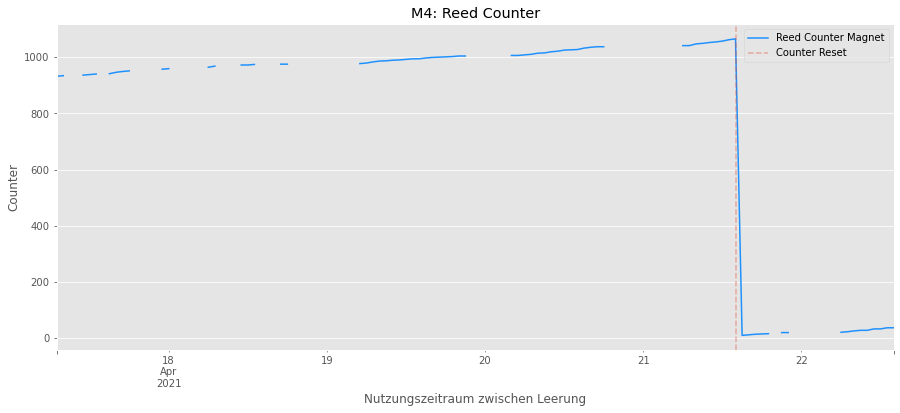

In [35]:
df_poc_m4['counter'].resample('H').max().plot(color='dodgerblue', figsize=(15,6), label='Reed Counter Magnet')
plt.axvline('2021-04-21 14:53:00.195000+00:00', linestyle='--', alpha=0.4, label='Counter Reset')
plt.title('M4: Reed Counter')
plt.ylabel('Counter')
plt.xlabel('Nutzungszeitraum zwischen Leerung')
plt.legend()
plt.savefig('./Jupyter Notebook Grafiken/M4_Messdaten Nutzungszeitraum.png')
plt.show()

In [36]:
counter_byreset = df_poc_m4.loc['2021-04-21 14:53:00.195000+00:00', 'counter'][0]
counter_start   = counter_start   = df_poc_m4.iloc[0, df_sensoneo.columns.get_loc('Distance')]
counter_ende    = df_poc_m4.iloc[-1, df_sensoneo.columns.get_loc('Distance')]

counter_zeitfenster = counter_byreset - counter_start + counter_ende
print('Magnet Auslösungen im Nutzungszeitraum: ', counter_zeitfenster, 'Achtung fehlende Daten')

# Messzeitraum durch Anzahl Messtage(6) * Zeitraum Leerung (8)
messtage = len(df_poc_m4.index.day.unique())
zeitraum = len(df_poc.index.day.unique())
lost_messtag = 1
counter_schätzung = (counter_zeitfenster / messtage) * zeitraum  + lost_messtag
print('Daten Hochrechnen bis zum 25.04: ', counter_schätzung)

Magnet Auslösungen im Nutzungszeitraum:  171.0 Achtung fehlende Daten
Daten Hochrechnen bis zum 25.04:  229.0


### M3: (POC-ACB, ex. Riegel Mag.)

In [37]:
# fast data cleaning, Sensor ID (M4) wählen und Zeitrum einschränken
df_poc_m3 = df_poc[df_poc['deviceId'] == '2203ACB']
df_poc_m3 = df_poc_m3[df_poc_m3['action'] == 'reed_counter']
df_poc_m3 = df_poc_m3[['deviceId','action','counter']]
df_poc_m3

,deviceId,action,counter
created,,,
2021-04-17 08:09:31.891000+00:00,2203ACB,reed_counter,380.0
2021-04-17 08:19:42.075000+00:00,2203ACB,reed_counter,381.0
2021-04-17 11:32:28.726000+00:00,2203ACB,reed_counter,382.0
2021-04-17 12:07:55.564000+00:00,2203ACB,reed_counter,383.0
2021-04-17 13:54:17.011000+00:00,2203ACB,reed_counter,384.0
...,...,...,...
2021-04-24 09:50:59.083000+00:00,2203ACB,reed_counter,516.0
2021-04-24 12:22:15.461000+00:00,2203ACB,reed_counter,517.0
2021-04-24 14:08:06.315000+00:00,2203ACB,reed_counter,518.0


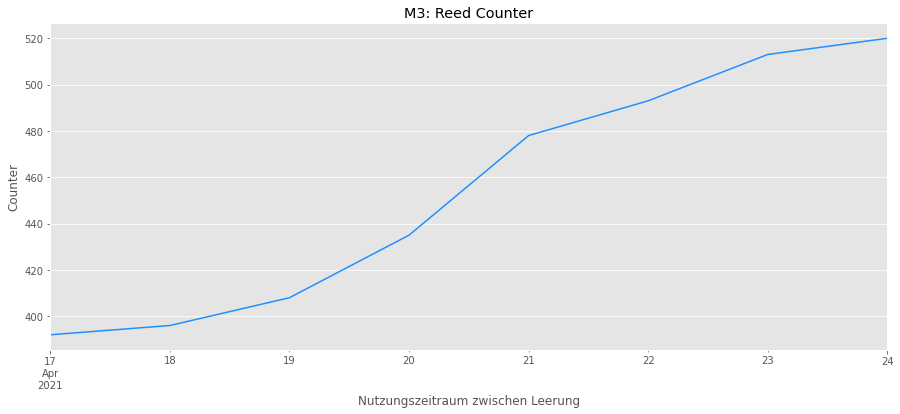

In [38]:
df_poc_m3['counter'].resample('D').max().plot(color='dodgerblue', figsize=(15,6), label='M3:Reed Counter Magnet')
plt.title('M3: Reed Counter')
plt.ylabel('Counter')
plt.xlabel('Nutzungszeitraum zwischen Leerung')
plt.savefig('./Jupyter Notebook Grafiken/M3_Messdaten Nutzungszeitraum.png')
plt.show()

In [39]:
counter_zeitfenster = df_poc_m3.iloc[-1, 2] - df_poc_m3.iloc[0, 2]
print('Magnet Auslösungen im Nutzungszeitraum: ', counter_zeitfenster)

Magnet Auslösungen im Nutzungszeitraum:  140.0


### B1: (PTH-04E, ex. Türe Beschl.)

In [40]:
# fast data cleaning, Sensor ID (M4) wählen und Zeitrum einschränken
df_poc_b1 = df_poc[df_poc['deviceId'] == '1F2504E']
df_poc_b1 = df_poc_b1[df_poc_b1['action'] == 'first_move']

# "first move" meldungen addieren
df_poc_b1['counter'] = np.where(df_poc_b1['action'] == 'first_move', 1, 0)
# index ordnen zum aufsummieren
df_poc_b1.sort_index(ascending=True, inplace=True)
df_poc_b1['counter'] = np.cumsum(df_poc_b1['counter'])

df_poc_b1 = df_poc_b1[['deviceId','action','counter']]
df_poc_b1

,deviceId,action,counter
created,,,
2021-04-17 08:06:48.314000+00:00,1F2504E,first_move,1
2021-04-17 13:58:15.543000+00:00,1F2504E,first_move,2
2021-04-17 17:34:37.112000+00:00,1F2504E,first_move,3
2021-04-17 20:30:19.058000+00:00,1F2504E,first_move,4
2021-04-18 06:53:51.163000+00:00,1F2504E,first_move,5
...,...,...,...
2021-04-24 06:49:00.897000+00:00,1F2504E,first_move,90
2021-04-24 10:05:23.131000+00:00,1F2504E,first_move,91
2021-04-24 12:21:31.467000+00:00,1F2504E,first_move,92


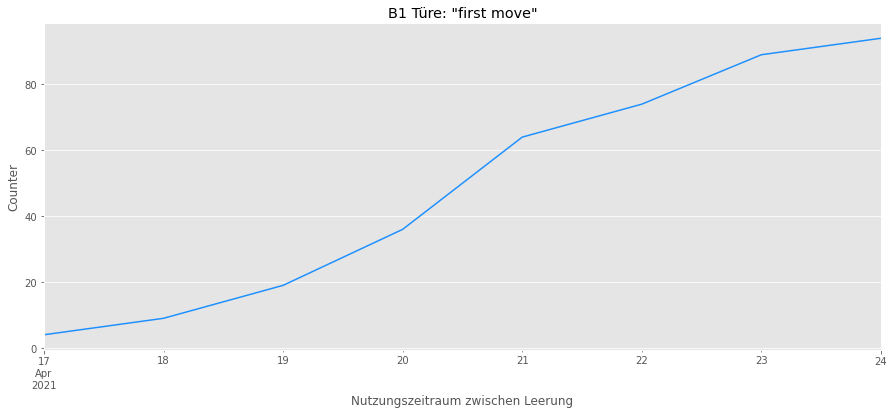

In [41]:
df_poc_b1['counter'].resample('D').max().plot(color='dodgerblue', figsize=(15,6), label='B1:Türe')
plt.title('B1 Türe: "first move"')
plt.ylabel('Counter')
plt.xlabel('Nutzungszeitraum zwischen Leerung')
plt.savefig('./Jupyter Notebook Grafiken/B1_Messdaten Nutzungszeitraum.png')
plt.show()

In [42]:
counter_zeitfenster_b1 = df_poc_b1.iloc[-1, 2]
print('Beschleunigung Auslösungen im Nutzungszeitraum: ', counter_zeitfenster_b1)

Beschleunigung Auslösungen im Nutzungszeitraum:  94


### B2: (PTH-047, ex. Riegel Besch)

In [43]:
# fast data cleaning, Sensor ID (M4) wählen und Zeitrum einschränken
#action_val = 'orientation_changed'
action_val = 'first_move'
df_poc_b2 = df_poc[df_poc['deviceId'] == '1F25047']
df_poc_b2 = df_poc_b2[df_poc_b2['action'] == action_val]

# "first move" meldungen addieren
df_poc_b2['counter'] = np.where(df_poc_b2['action'] == action_val, 1, 0)
# index ordnen zum aufsummieren
df_poc_b2.sort_index(ascending=True, inplace=True)
df_poc_b2['counter'] = np.cumsum(df_poc_b2['counter'])

df_poc_b2 = df_poc_b2[['deviceId','action','counter']]
df_poc_b2

,deviceId,action,counter
created,,,
2021-04-17 07:50:43.396000+00:00,1F25047,first_move,1
2021-04-17 08:06:45.853000+00:00,1F25047,first_move,2
2021-04-17 08:17:05.547000+00:00,1F25047,first_move,3
2021-04-17 11:29:25.676000+00:00,1F25047,first_move,4
2021-04-17 12:03:36.008000+00:00,1F25047,first_move,5
...,...,...,...
2021-04-24 13:44:25.643000+00:00,1F25047,first_move,206
2021-04-24 14:06:08.005000+00:00,1F25047,first_move,207
2021-04-24 14:23:01.758000+00:00,1F25047,first_move,208


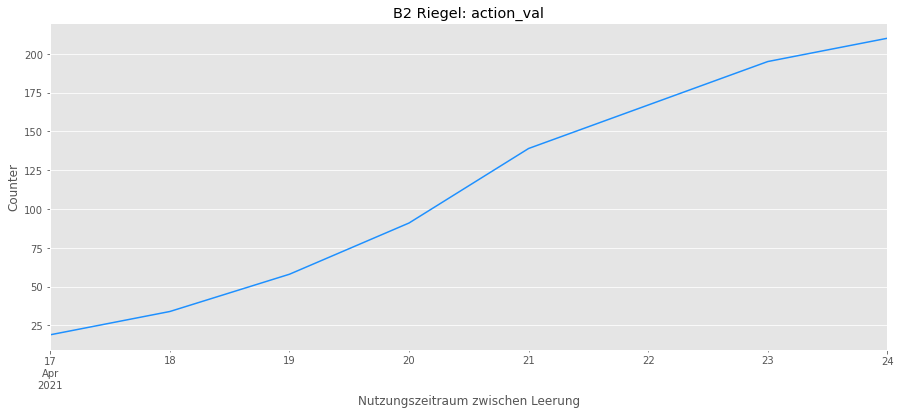

In [44]:
df_poc_b2['counter'].resample('D').max().plot(color='dodgerblue', figsize=(15,6), label='B2:Riegel')
plt.title('B2 Riegel: action_val')
plt.ylabel('Counter')
plt.xlabel('Nutzungszeitraum zwischen Leerung')
plt.savefig('./Jupyter Notebook Grafiken/B1_Messdaten Nutzungszeitraum.png')
plt.show()

In [45]:
counter_zeitfenster_b2 = df_poc_b2.iloc[-1, 2]
print('Beschleunigung Auslösungen im Nutzungszeitraum: ', counter_zeitfenster_b2)

Beschleunigung Auslösungen im Nutzungszeitraum:  210


### Korrelationen zwischen Beschleunigungssensoren
### Berechnungen

In [46]:
# B1 misst Türöffnungen
df_poc_b1_count = df_poc_b1[['counter']].resample('H').max()
df_poc_b1_count.fillna(method='ffill', inplace=True)
df_poc_b1_count.head(5)

,counter
created,
2021-04-17 08:00:00+00:00,1.0
2021-04-17 09:00:00+00:00,1.0
2021-04-17 10:00:00+00:00,1.0
2021-04-17 11:00:00+00:00,1.0
2021-04-17 12:00:00+00:00,1.0


In [47]:
# B2 misst Türöffnung und Riegelbewegung?! Faktor 2 höher
df_poc_b2_count = df_poc_b2[['counter']].resample('H').max()
df_poc_b2_count = df_poc_b2_count[1:]
df_poc_b2_count.fillna(method='ffill', inplace=True)
df_poc_b2_count.head(5)

,counter
created,
2021-04-17 08:00:00+00:00,3.0
2021-04-17 09:00:00+00:00,3.0
2021-04-17 10:00:00+00:00,3.0
2021-04-17 11:00:00+00:00,4.0
2021-04-17 12:00:00+00:00,6.0


##### Beispiel [link](https://realpython.com/numpy-scipy-pandas-correlation-python/) Korrelation mit scipy

In [48]:
x = list(df_poc_b1_count['counter'])
y = list(df_poc_b2_count['counter'])

In [49]:
print(scipy.stats.pearsonr(x, y)[0])    # Pearson's r
print(scipy.stats.spearmanr(x, y)[0])   # Spearman's rho

0.9976352194439491
0.9993049403776549


In [50]:
r, p = scipy.stats.pearsonr(x, y)
print('Pearson: ', r)    # Pearson's r
print('Spearman: ', scipy.stats.spearmanr(x, y).correlation)   # Spearman's rho

Pearson:  0.9976352194439491
Spearman:  0.9993049403776549


Somit eine fast perfekte positive Korrelation

### Grafiken
##### Beispiel [link](https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy)

(0.0, 12.0)

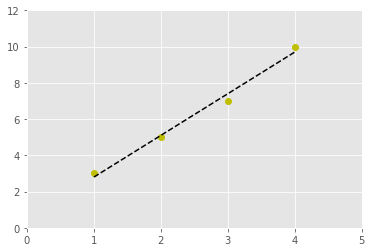

In [51]:
x = [1,2,3,4]
y = [3,5,7,10] # 10, not 9, so the fit isn't perfect

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y, 'yo', x, poly1d_fn(x), '--k')
plt.xlim(0, 5)
plt.ylim(0, 12)

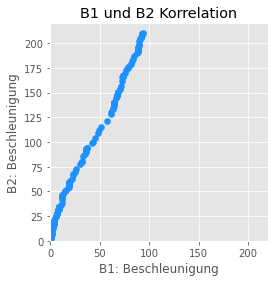

In [52]:
plt.scatter(df_poc_b1_count, df_poc_b2_count, color='dodgerblue')
plt.xlim(0, 220)
plt.ylim(0, 220)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('B1 und B2 Korrelation')
plt.ylabel('B2: Beschleunigung')
plt.xlabel('B1: Beschleunigung')
plt.savefig('./Jupyter Notebook Grafiken/B1_B2 Korrelation.png')
plt.show()

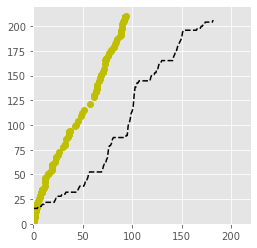

In [53]:
# versuch Regressionslinie zu erstellen
x = list(df_poc_b1_count['counter'])
y = list(df_poc_b2_count['counter'])

coef = np.polyfit(x, y,1)
poly1d_fn = np.poly1d(coef)

plt.plot(x, y, 'yo', poly1d_fn(x), '--k')
plt.xlim(0, 220)
plt.ylim(0, 220)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Korrelationen zwischen Beschleunigung- und Magnetsensoren
### Berechnungen

In [54]:
# B1 misst Türöffnungen
df_poc_b1_count = df_poc_b1[['counter']].resample('H').max()
df_poc_b1_count.fillna(method='ffill', inplace=True)
df_poc_b1_count = df_poc_b1_count[:-7]
df_poc_b1_count

,counter
created,
2021-04-17 08:00:00+00:00,1.0
2021-04-17 09:00:00+00:00,1.0
2021-04-17 10:00:00+00:00,1.0
2021-04-17 11:00:00+00:00,1.0
2021-04-17 12:00:00+00:00,1.0
...,...
2021-04-24 11:00:00+00:00,91.0
2021-04-24 12:00:00+00:00,92.0
2021-04-24 13:00:00+00:00,92.0


In [55]:
# M3 misst Magnet am Riegel
df_poc_m3_count = df_poc_m3[['counter']].resample('H').max()
df_poc_m3_count.fillna(method='ffill', inplace=True)
df_poc_m3_count

,counter
created,
2021-04-17 08:00:00+00:00,381.0
2021-04-17 09:00:00+00:00,381.0
2021-04-17 10:00:00+00:00,381.0
2021-04-17 11:00:00+00:00,382.0
2021-04-17 12:00:00+00:00,383.0
...,...
2021-04-24 11:00:00+00:00,516.0
2021-04-24 12:00:00+00:00,517.0
2021-04-24 13:00:00+00:00,517.0


In [56]:
# Berechnungen Korrelation mit Scipy
x = list(df_poc_b1_count['counter'])
y = list(df_poc_m3_count['counter'])

r, p = scipy.stats.pearsonr(x, y)
print('Pearson: ', r)    # Pearson's r
print('Spearman: ', scipy.stats.spearmanr(x, y).correlation)   # Spearman's rho

Pearson:  0.9990116600022052
Spearman:  0.9989645262874067


Somit eine fast perfekte positive Korrelation

### Grafiken

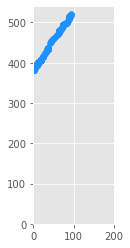

In [57]:
plt.scatter(df_poc_b1_count, df_poc_m3_count, color='dodgerblue')
plt.xlim(0, 200)
plt.ylim(0, 540)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [58]:
# m3 Offset anpassen
df_poc_m3_count = df_poc_m3_count['counter'] - 380
df_poc_m3_count.head(2)

created
2021-04-17 08:00:00+00:00    1.0
2021-04-17 09:00:00+00:00    1.0
Freq: H, Name: counter, dtype: float64

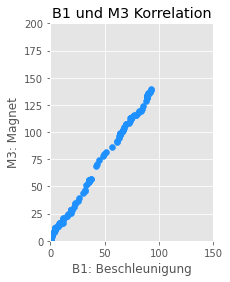

In [59]:
plt.scatter(df_poc_b1_count, df_poc_m3_count, color='dodgerblue')
plt.xlim(0, 150)
plt.ylim(0, 200)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('B1 und M3 Korrelation')
plt.ylabel('M3: Magnet')
plt.xlabel('B1: Beschleunigung')
plt.savefig('./Jupyter Notebook Grafiken/B1_M3 Korrelation.png')
plt.show()

### Korrelationen zwischen Beschleunigung- und Magnetsensoren
### Berechnungen

In [60]:
# M3 Magnet am Türriegel
df_poc_m3_count

created
2021-04-17 08:00:00+00:00      1.0
2021-04-17 09:00:00+00:00      1.0
2021-04-17 10:00:00+00:00      1.0
2021-04-17 11:00:00+00:00      2.0
2021-04-17 12:00:00+00:00      3.0
                             ...  
2021-04-24 11:00:00+00:00    136.0
2021-04-24 12:00:00+00:00    137.0
2021-04-24 13:00:00+00:00    137.0
2021-04-24 14:00:00+00:00    139.0
2021-04-24 15:00:00+00:00    140.0
Freq: H, Name: counter, Length: 176, dtype: float64

In [61]:
# Offset anpassen
df_poc_m3_count_o = df_poc_m3_count.iloc[1:-11]
df_poc_m3_count_o

created
2021-04-17 09:00:00+00:00      1.0
2021-04-17 10:00:00+00:00      1.0
2021-04-17 11:00:00+00:00      2.0
2021-04-17 12:00:00+00:00      3.0
2021-04-17 13:00:00+00:00      4.0
                             ...  
2021-04-24 00:00:00+00:00    133.0
2021-04-24 01:00:00+00:00    133.0
2021-04-24 02:00:00+00:00    133.0
2021-04-24 03:00:00+00:00    133.0
2021-04-24 04:00:00+00:00    133.0
Freq: H, Name: counter, Length: 164, dtype: float64

In [62]:
# Füllstandsensor
df_sensoneof2 = df_sensoneof2[['Distance']]
df_sensoneof2 = df_sensoneof2.sort_index(ascending=True)
df_sensoneof2 = df_sensoneof2['2021-04-17 08:00:00' : '2021-04-24 15:00:00']
df_sensoneof2 = df_sensoneof2.resample('H').max().fillna(method='ffill')
df_sensoneof2 = df_sensoneof2['Distance']
df_sensoneof2

Timestamp
2021-04-17 09:00:00    21.0
2021-04-17 10:00:00    21.0
2021-04-17 11:00:00    23.0
2021-04-17 12:00:00    23.0
2021-04-17 13:00:00    17.0
                       ... 
2021-04-24 09:00:00     5.0
2021-04-24 10:00:00     5.0
2021-04-24 11:00:00     5.0
2021-04-24 12:00:00    11.0
2021-04-24 13:00:00    11.0
Freq: H, Name: Distance, Length: 173, dtype: float64

In [63]:
df_sensoneof2_o = df_sensoneof2.iloc[0:-9]
df_sensoneof2_o

Timestamp
2021-04-17 09:00:00    21.0
2021-04-17 10:00:00    21.0
2021-04-17 11:00:00    23.0
2021-04-17 12:00:00    23.0
2021-04-17 13:00:00    17.0
                       ... 
2021-04-24 00:00:00    49.0
2021-04-24 01:00:00    49.0
2021-04-24 02:00:00    49.0
2021-04-24 03:00:00    49.0
2021-04-24 04:00:00    49.0
Freq: H, Name: Distance, Length: 164, dtype: float64

In [64]:
# Berechnungen Korrelation mit Scipy
x = list(df_poc_m3_count_o)
y = list(df_sensoneof2_o)

r, p = scipy.stats.pearsonr(x, y)
print('Pearson: ', r)    # Pearson's r
print('Spearman: ', scipy.stats.spearmanr(x, y).correlation)   # Spearman's rho

Pearson:  0.9207488519656363
Spearman:  0.9617162808174503


Trotz den schwankenden Messwerten des Fülsltandsensor eine ganz gute positive Korrelation

### Grafiken

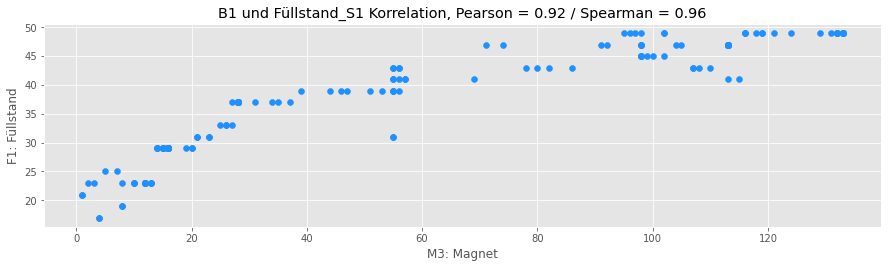

In [66]:
plt.figure(figsize=(15,6))
plt.scatter(df_poc_m3_count_o, df_sensoneof2_o, color='dodgerblue')
#plt.xlim(0, 150)
#plt.ylim(0, 200)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('B1 und Füllstand_S1 Korrelation, Pearson = 0.92 / Spearman = 0.96')
plt.ylabel('F1: Füllstand')
plt.xlabel('M3: Magnet')
plt.savefig('./Jupyter Notebook Grafiken/B1_Füllstand Korrelation.png')
plt.show()